In [17]:
import os
import numpy as np 
import matplotlib.pyplot as plt

Introduce all necessary functions:
    - reading the SDSS-CRTS cross-matched catalogue 
    - make cuts in the available objecs according to selection criteria 

In [63]:
def get_qso_catalog(catalog):
    if catalog == 's82drw':
        File = 'CRTS_SDSS_cross_matched_qso_s82drw_catalog.txt'
    if catalog == 'DB_QSO':
        File = 'CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File, dtype=str)
    qso_catalog = {}
    print 'Zipping CRTS-SDSS quasars catalog from ', File, ' ...'
    for label, column in zip(colnames, datatable.T):
        qso_catalog[label] = column
    
    qso_names = np.genfromtxt('CRTS_SDSS_cross_matched_qso_names.txt', dtype=str)    
    for i in range(len(qso_names)):
        qso_names[i] = qso_names[i][4:-4]
    print 'Read in ', len(qso_catalog['redshift']), ', quasars from CRTS'
    return  colnames, qso_catalog, qso_names
    
def get_stars_catalog():
    File = 'CRTS_SDSS_cross_matched_stars_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File)
    stars_catalog = {}
    print 'zipping CRTS-SDSS stars catalog...'
    for label, column in zip(colnames, datatable.T):
        stars_catalog[label] = column
        
    return  colnames, stars_catalog

cols1, qso_cat, qso_names = get_qso_catalog(catalog='DB_QSO') 
cols2 , star_cat= get_stars_catalog()

# Perform cuts 
def cut_qso(qso_cat=qso_cat, qso_names=qso_names, mMin=-9, mMax=19, 
            mErrMin = -9, mErrMax = 0.3,cut_mag='r', report_mag = 'r'):

    mask_mag = (qso_cat[cut_mag].astype(float) > mMin) * (qso_cat[cut_mag].astype(float) < mMax) 
    mask_err = (qso_cat['CRTS_avg_e'].astype(float) > mErrMin) * (qso_cat['CRTS_avg_e'].astype(float) < mErrMax)
    mask = mask_mag * mask_err 
    qso_id = qso_names[mask]
    qso_mags = qso_cat[report_mag][mask]
    print '\n These cuts reduced the number of qso  in the sample from', \
          len(qso_cat['redshift']), ' to ', len(qso_id)
    return  qso_id, mask , qso_mags

def cut_stars(star_cat=star_cat, mMin=-9, mMax=19, mErrMin = -9, 
              mErrMax = 0.3, gi_Min = -1, gi_Max=1 , cut_mag='r_mMed',
              report_mag = 'r_mMed'):

    mask_mag = (star_cat[cut_mag] > mMin) * (star_cat[cut_mag] < mMax) 
    mask_err = (star_cat['CRTS_Merr'] > mErrMin) * (star_cat['CRTS_Merr'] < mErrMax)
    SDSS_gi = star_cat['g_mMed'] - star_cat['i_mMed']
    mask_color = (SDSS_gi > gi_Min ) * (SDSS_gi < gi_Max)
    mask = mask_mag * mask_err * mask_color
    star_id_f = star_cat['crts_id'][mask]
    star_mags = star_cat[report_mag][mask]
    # convert floats to strings without comma and zeros
    star_id = np.array(["{:.0f}".format(name) for name in star_id_f])
    print '\n These cuts reduced the number of stars  in the sample from', \
          len(star_cat['CRTS_M']), ' to ', len(star_id)
    return  star_id, star_mags


Zipping CRTS-SDSS quasars catalog from  CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS
zipping CRTS-SDSS stars catalog...


Introduce xi, ei reading functions

In [62]:
qso_cat['CRTS_id']

array(['001053.56+000642.9', '001050.95-003133.2', '001047.99-001830.1',
       ..., '235738.83+000329.8', '235737.96+003227.8',
       '235736.27+003056.4'], 
      dtype='|S18')

1) Use SDSS g-mag, read 18-18.5 files only 

In [64]:
Min = 18
Max = 18.5 
cut_mag = 'g'
report_mag = 'g'

print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))
print('\n Reporting SDSS %s  '% report_mag)


good_ids_S_blue, S_blue_mags  = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1, gi_Max=1, 
                                          cut_mag=cut_mag + '_mMed', report_mag=report_mag + '_mMed')
good_ids_S_red, S_red_mags = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, gi_Max=3,
                                        cut_mag=cut_mag + '_mMed', report_mag=report_mag + '_mMed')
good_ids_QSO, mask_qso, qso_mags = cut_qso(mMin = Min, mMax=Max, mErrMax = 0.3, cut_mag=cut_mag,report_mag=report_mag)


Using now only lightcurves with SDSS  18.000000< g < 18.500000

 Reporting SDSS g  

 These cuts reduced the number of stars  in the sample from 47787  to  1463

 These cuts reduced the number of stars  in the sample from 47787  to  1136

 These cuts reduced the number of qso  in the sample from 7601  to  239


2) Save names of stars, qso 
- pattern for name, SDSS_mag, CRTS_avg_err, CRTS_avg_mag

18-18.5_g-sel_starsB_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag

18-18.5_g-sel_starsR_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag

18-18.5_g-sel_QSO_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag

In [81]:
# Grab CRTS_avg_err, CRTS_avg_mag

cat_starB_CRTS_Merr = [star_cat['CRTS_Merr'][star_cat['crts_id']==star][0] for star in good_ids_S_blue.astype(float)]
cat_starB_CRTS_M = [star_cat['CRTS_M'][star_cat['crts_id']==star][0] for star in good_ids_S_blue.astype(float)]

cat_starR_CRTS_Merr = [star_cat['CRTS_Merr'][star_cat['crts_id']==star][0] for star in good_ids_S_red.astype(float)]
cat_starR_CRTS_M = [star_cat['CRTS_M'][star_cat['crts_id']==star][0] for star in good_ids_S_red.astype(float)]

cat_qso_CRTS_Merr = [qso_cat['CRTS_avg_e'][qso_cat['CRTS_id']==qso][0].astype(float) for qso in good_ids_QSO]
cat_qso_CRTS_M = [qso_cat['CRTS_avg_m'][qso_cat['CRTS_id']==qso][0].astype(float) for qso in good_ids_QSO]

In [86]:
data = np.column_stack((good_ids_S_blue,S_blue_mags, cat_starB_CRTS_Merr, cat_starB_CRTS_M ))
fname=str(Min)+'-'+str(Max)+'_'+cut_mag+'starsB_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag.txt'
print fname
np.savetxt(fname, data, fmt='%s  '*4)

data = np.column_stack((good_ids_S_red,S_red_mags, cat_starR_CRTS_Merr, cat_starR_CRTS_M ))
fname=str(Min)+'-'+str(Max)+'_'+cut_mag+'starsR_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag.txt'
print fname
np.savetxt(fname, data, fmt='%s  '*4)

data = np.column_stack((good_ids_QSO,qso_mags, cat_qso_CRTS_Merr, cat_qso_CRTS_M ))
fname=str(Min)+'-'+str(Max)+'_'+cut_mag+'qso_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag.txt'
print fname
np.savetxt(fname, data, fmt='%s  '*4)

18-18.5_gstarsB_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag.txt
18-18.5_gstarsR_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag.txt
18-18.5_gqso_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag.txt


In [87]:
# Just a check : that the order in qso_names from a file is indeed the same as the catalog...
cat_gmags_qso = [qso_cat['g'][qso_cat['CRTS_id'] == name][0].astype(float)  for name in good_ids_QSO]
# Just to make sure  : all the mags extracted in the new way are exactly the same 
np.sum(np.array(cat_gmags_qso) - np.array(qso_mags).astype(float))

0.0

In [ ]:
3) Use SDSS r-mag, read 18-18.5 files only

 

4) Save names of stars, qso
- pattern for name, SDSS_mag, CRTS_avg_err, CRTS_avg_mag
18-18.5_r-sel_starsB_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_r-sel_starsR_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_r-sel_QSO_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag


5) Make three bins : 
- stars_B that are in both g and r , those only in g, and those only in  r   (similarly for stars_R, QSO)
--> get lists of names of objects in each bin
18-18.5_binr_starsB_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_bing_starsB_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_bingr_starsB_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag

18-18.5_binr_starsR_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_bing_starsR_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_bingr_starsR_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag

18-18.5_binr_QSO_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_bing_QSO_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag
18-18.5_bingr_QSO_name_SDSS-mag_CRTS-avg-err_CRTS-avg-mag

--> for each object, get the CRTS_avg_err,  etc. from the catalogue 
--> using this data, calculate median CRTS mag for each bin, and median CRTS_avg_err 

         binr    bing    bingr   
starR
starB    median_CRTS_mag
QSO


         binr    bing    bingr   
starR
starB    median_CRTS_avg_err
QSO


6) Read in xi, ei for stars_B in each bin  (similar for Stars_R and QSO), select log(tau)<1.7 , save as files per bin:

18-18.5_bin_g_starsB_logt_1.7_xi_ei_name
18-18.5_bin_r_starsB_logt_1.7_xi_ei_name
18-18.5_bin_gr_starsB_logt_1.7_xi_ei_name

18-18.5_bin_g_starsR_logt_1.7_xi_ei_name
18-18.5_bin_r_starsR_logt_1.7_xi_ei_name
18-18.5_bin_gr_starsR_logt_1.7_xi_ei_name

18-18.5_bin_g_QSO_logt_1.7_xi_ei_name
18-18.5_bin_r_QSO_logt_1.7_xi_ei_name
18-18.5_bin_gr_QSO_logt_1.7_xi_ei_name

7) Calculate median ei per bin 

         binr    bing    bingr   
starR
starB    median_CRTS_err
QSO



In [1]:
import numpy as np

In [5]:
a=np.array([1,2,3])
b = np.array([2,3,4])

In [6]:
intersection = np.intersect1d(a,b)
intersection

array([2, 3])

In [7]:
left = np.setdiff1d(a,b)
left

array([1])

In [9]:
right = np.setdiff1d(b,a)
right


array([4])

In [12]:
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2

<matplotlib_venn._common.VennDiagram instance at 0x7fce45a76bd8>

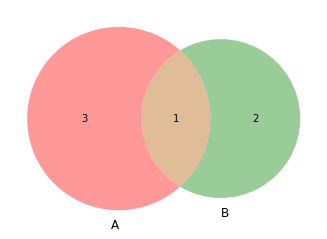

In [14]:
%matplotlib inline
venn2(subsets=(3,2,1))

<matplotlib_venn._common.VennDiagram instance at 0x7fce4599def0>

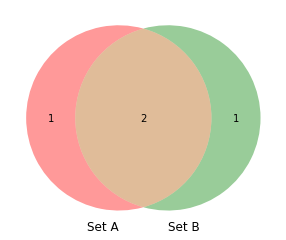

In [16]:
# This shows the number of objeccts in each category 
venn2([set(a),set(b)], ('Set A', 'Set B') )


In [29]:
# inside the main loop : get tau, delflx from a master file, either qso or star
def add_tau_delflx(File, inDir, data, fc):
    # read in storage arrays
    delflx = data[0]  
    tau = data[1]
    err = data[2]
    master_acc_list = data[3]   
    
    # grab the object name 
    master_name = File[3:-4]
    
    # read in the i-th master file 
    master =  np.genfromtxt(inDir+File, dtype=str)
    
    # read in tau,  del_mag,  del_mag_err for quasars on the list 
    delflx = np.append(delflx, master[:,0].astype(float))
    tau = np.append(tau, master[:,1].astype(float))
    
    if fc is not None :  # correct new master rows only if  asked for 
        err = np.append(err, master[:,2].astype(float)*fc)
    else:                # otherwise read in without any correction
        err = np.append(err, master[:,2].astype(float))
    master_names  = np.append(master_acc_list, np.array(len(master[:,0])*[master_name]))
    
    return delflx, tau, err, master_names
    
def read_xi_ei(inDirStars, good_ids_S_blue, good_ids_S_red, inDirQSO,
                 good_ids_QSO, xi_ei_data=None, fc=None):
                     
    inDir_S       = inDirStars
    good_ids_S_blue    = good_ids_S_blue
    good_ids_S_red    = good_ids_S_red
    inDir_Q       = inDirQSO
      
    
    # Read the Stellar Master file names 
    masterFiles_S = os.listdir(inDir_S)
    masterFilesS1 = [name[3:-4] for name in masterFiles_S]
    
    good_masterSB = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_blue)]
    good_masterSR = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_red)]
    
    # Read the QSO Master file names 
    masterFiles_Q = os.listdir(inDir_Q)
    masterFilesQ1 = [name[3:-4] for name in masterFiles_Q]
    good_masterQ = np.array(masterFiles_Q)[np.in1d(masterFilesQ1, good_ids_QSO)]
    

  
    # If no previous read-in xi, ei exists, initialize arrays    
    if xi_ei_data is None : 
        print 'making new delflx, tau, xi arrays'
        delflx_S      = np.empty(0,dtype=float)
        tau_S         = np.empty(0,dtype=float)
        err_S         = np.empty(0,dtype=float)
        master_acc_list_S = np.empty(0, dtype=str)
    
        
       
        delflx_Q      = np.empty(0,dtype=float)
        tau_Q         = np.empty(0,dtype=float)
        err_Q         = np.empty(0,dtype=float)
        master_acc_list_Q = np.empty(0, dtype=str)
        
        # Initialize the data structures to which more and more delta_t and delta_mag
        # are addded from each consecutive master file 
        qso_data = [delflx_Q, tau_Q, err_Q, master_acc_list_Q] 
        star_data_blue = [delflx_S, tau_S, err_S, master_acc_list_S]
        star_data_red  = [delflx_S, tau_S, err_S, master_acc_list_S]
        
    else:
        print 'using existing xi ei arrays'
        qso_data = xi_ei_data[0]
        star_data_blue = xi_ei_data[1]
        star_data_red = xi_ei_data[2]
        
    print('\n')
    c = 0
    for File in good_masterQ: #  len(masterFiles_Q)
        #print 'Reading in ', File
        
        qso_data = add_tau_delflx(File,inDir_Q, qso_data, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterQ))
            print('\r----- Already read %d%% of qso'%pers),
    
    print('\n')
    c = 0                   
    for File in good_masterSB:    # [:len(good_masterQ)]
        #print 'Reading in ', File
        star_data_blue = add_tau_delflx(File, inDir_S,star_data_blue, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterQ))
            print('\r----- Already read %d%% of Blue Stars'%pers),  
    print('\n')
    c = 0                         
    for File in good_masterSR:   # [:len(good_masterQ)]
        #print 'Reading in ', File
        star_data_red = add_tau_delflx(File, inDir_S, star_data_red, fc)      
        c += 1               
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterQ))
            print('\r----- Already read %d%% of Red Stars'%pers),          
                     
    print('returning xi, ei for ... %d objects'%len(good_masterQ))
                            
    return  qso_data, star_data_blue, star_data_red